## Building a basic Chatbot with Langgraph (Graph API)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]
    
graph_builder = StateGraph(State)

In [ ]:
graph_builder

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [ ]:
llm

In [ ]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

In [ ]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [ ]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

In [ ]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response=graph.invoke({"messages":"Hi"})

In [ ]:
response["messages"][-1].content

### Chatbot with Tools

In [ ]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

In [ ]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [ ]:
tools=[tool,multiply]
llm_with_tool=llm.bind_tools(tools)
llm_with_tool

In [ ]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response = graph.invoke({"messages":"What is the recent ai news"})

In [ ]:
response['messages'][-1].content

In [ ]:
for m in response['messages']:
    m.pretty_print()

In [ ]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

In [ ]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

* Here, the LLM was only able to answer the first part of the question
* It was unable to answer the second half of the question since our node of only to one tool call and then it would go to the end node
* To resolve this, ReACT architecture would come into play

### ReAct Agent Architecture

3 main key factors of a ReAct Agent are:
1. Act
2. Observe
3. Reason

![Screenshot 2025-07-28 at 8.15.24 PM.png](<attachment:Screenshot 2025-07-28 at 8.15.24 PM.png>)
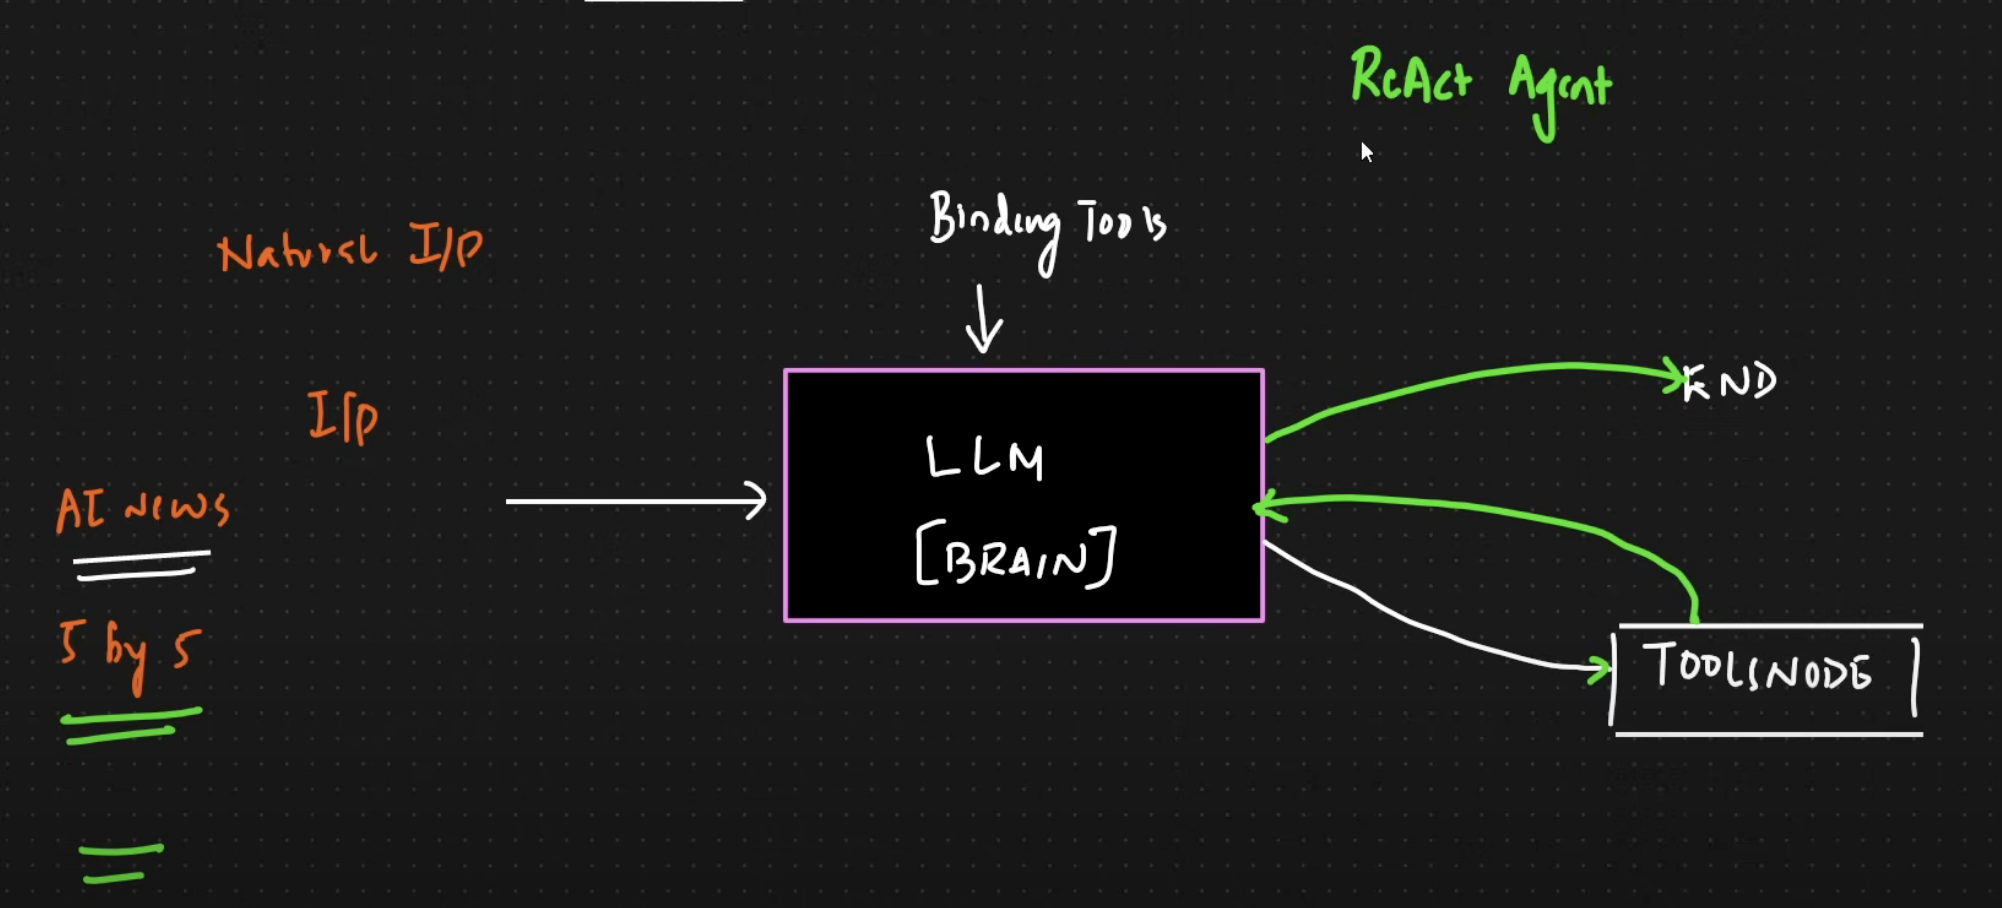

In [ ]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()